# settings

## install

In [1]:
!pip install catboost
# !pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## imports

In [2]:
import os
import random
import re
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA, KernelPCA

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE

import librosa
import librosa.display
import IPython.display as ipd

import tensorflow as tf
import torch

from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import xgboost as xgb
import lightgbm as lgbm
import catboost as cat
# import optuna

In [3]:
# 경로 설정

os.chdir('/content/drive/MyDrive/Colab Notebooks/aichallenge')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/aichallenge'

## GPU

In [4]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found')
    pass
else:
    print(f'GPU found at: {device_name}')

GPU found at: /device:GPU:0


## functions

In [5]:
def fix_random_seed(random_seed):
    """랜덤시드 고정"""
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print('### random_seed fixed ###\n')


def drop_from_origin(origin_df_in, target_df_in, target_cols):
    #// DataFrame) origin_df_in: 원본 데이터프레임
    #// DataFrame) target_df_in: 원본에서 뺄 데이터프레임
    #// list) target_cols: 중복 검사할 column들
    #// 리턴: origin에서 target을 뺀 여집합

    #// origin과 target은 column 리스트가 일치해야 함
    
    origin_df = origin_df_in.copy()
    target_df = target_df_in.copy()
    
    origin_concat_target = pd.concat([origin_df, target_df], axis=0)
    ret = origin_concat_target.drop_duplicates(subset=target_cols, keep=False)
    ret.reset_index(drop=True, inplace=True)
    
    return ret


def get_gt_from_origin(origin_df_in, target_df_in, target_cols, label_col, id_col):
    #// DataFrame) origin_df_in: 원본 데이터프레임              (column: [label, target_cols])
    #// DataFrame) target_df_in: 원본에서 gt를 찾을 데이터프레임 (column: [id, target_cols])
    #// list) target_cols: 중복 검사할 column들            (X값이 될 column 리스트)
    #// X값은 전부 numeric
    #// string) label_col: y값 column명
    #// string) id_col: id값 column명
    #// returns: DataFrame) 원본에서 X값이 중복인 row들의 id, X, ground truth

    origin_df = origin_df_in.copy()
    target_df = target_df_in.copy()
    origin_df = origin_df.drop_duplicates(subset=target_cols)
    
    origin_concat_target = pd.concat([origin_df, target_df], axis=0)
    origin_concat_target.reset_index(drop=True, inplace=True)
    
    flags = origin_concat_target.duplicated(subset=target_cols, keep=False)
    flags = pd.DataFrame(flags, columns=['dupl'])
    origin_concat_target = pd.concat([origin_concat_target, flags],axis=1)
    
    with_gt_id = origin_concat_target[origin_concat_target['dupl']==True]
    with_gt_id.reset_index(drop=True, inplace=True)
    
    print(with_gt_id.shape)
    cut = len(with_gt_id) / 2

    with_gt = with_gt_id.iloc[:int(cut),:]
    with_id = with_gt_id.iloc[int(cut):,:]

    if len(with_gt) != len(with_id): 
        print("length error")
        return 0
    
    with_gt['std'] = with_gt[target_cols].std(axis=1)
    with_id['std'] = with_id[target_cols].std(axis=1)

    if with_gt['std'].nunique() != with_id['std'].nunique(): 
        print("uniqueness error")
        return 0
    
    with_gt = with_gt.sort_values(by=with_gt.columns[-1])
    with_id = with_id.sort_values(by=with_id.columns[-1])
    
    with_gt.reset_index(drop=True, inplace=True)
    with_id.reset_index(drop=True, inplace=True)
    
    with_id[label_col] = with_gt[label_col]
    
    with_id = with_id.drop(['dupl', 'std'], axis=1)

    id = with_id[id_col]
    X_dupl = with_id[target_cols]
    gt = with_id[label_col] 
    ret = pd.concat([id, X_dupl, gt], axis=1)
    ret.reset_index(drop=True, inplace=True)
    return ret


def inverse_spectral_density(in_df, hz_cols, label_col):
    """푸리에 변환된 spectral density를 역으로 wave 데이터로 변환"""
    #// hz_cols: 주파수 column 이름 리스트  (X값)
    #// label_col: 클래스 column 이름       (y값)
    #// in_df: 원본 pandas dataframe

    spectral_df = in_df.copy()
    
    spectral_df_freq = spectral_df[hz_cols]
    spectral_df_label = spectral_df[label_col]
    
    freq_array = [int(re.sub(r'[^0-9]', '', x)) for x in spectral_df_freq.columns]
    freq_array = np.array(freq_array)
    
    ret = []
    t = []
    for i in range(len(spectral_df)):
        amplitude = spectral_df_freq.iloc[i].values
        Zxx = np.array([freq_array, amplitude]).T
        t, x = signal.istft(Zxx)
        ret.append(x)
    ret = np.asarray(ret)
    ret = pd.DataFrame(ret, columns=t)
    
    return ret, spectral_df_label

def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(14, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b--', label='train_loss')
    ax1.plot(epochs, val_loss, 'r:', label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, acc, 'b--', label='train_acc')
    ax2.plot(epochs, val_acc, 'r:', label='val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.grid()
    ax2.legend()

    plt.show()

## read / sort / split

In [6]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sub = pd.read_csv('./data/sample_submission.csv')
aihub = pd.read_csv('./data/aihub.csv')

cols = [x for x in train.columns if 'HZ' in x]
cols_hz = [int(x[:-2]) for x in cols]

# aihub 데이터에서 test 데이터의 레이블 찾아서 dataframe으로 반환
public = get_gt_from_origin(aihub, test, cols, 'leaktype', 'id')

print('### check shape ###')
train.shape, test.shape, sub.shape, aihub.shape, public.shape

(15640, 541)
### check shape ###


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((33600, 514), (7820, 514), (7820, 2), (78204, 539), (7820, 515))

In [7]:
# submission과 test의 input data 순서 동일하게 맞춰 줌

sorter = list(sub['id'])

test.set_index('id', inplace=True)
public.set_index('id', inplace=True)

test = test.loc[sorter].reset_index()
public = public.loc[sorter].reset_index()

print('### check sorted ###\n')
print(f'sub:  {sub["id"].values[:5]}')
print(f'test: {test["id"].values[:5]}')
print(f'public:  {public["id"].values[:5]}')

### check sorted ###

sub:  ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']
test: ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']
public:  ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']


In [8]:
X_train = train[cols]
y_train = train['leaktype']

X_test = test[cols]
y_test = public['leaktype']

print('### check shape ###')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

### check shape ###


((33600, 513), (33600,), (7820, 513), (7820,))

## config

In [9]:
# 랜덤시드 고정
seed = 42
fix_random_seed(random_seed=seed)

# encdoer / decoder
encoder = {'out': 0, 'in': 1, 'normal': 2, 'noise': 3, 'other': 4}
decoder = {v: k for k, v in encoder.items()}

# aihub 데이터 비율
aihub_ratio = {'out': 0, 'in': 1, 'normal': 2, 'noise': 3, 'other': 4}

# lgbm params
early_stopping_rounds = 50
lgbm_params = {'n_estimators': 500, 'learning_rate': 0.1, 'feature_fraction': 0.5, 
               'bagging_fraction': 0.67, 'bagging_freq': 1, 'verbose': 0, 
               'n_jobs': 6, 'random_state': seed, 'num_class': 5}

# DL params
optimizer = optimizers.Adamax()
loss = 'categorical_crossentropy'
batch_size = 128
epochs = 50
validation_split = 0.1
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

### random_seed fixed ###



# Preprocess

## Oversample

In [10]:
smote = SMOTE(random_state=seed)
# adasyn = ADASYN(random_state=seed)
# bsmote = BorderlineSMOTE(random_state=seed)
# ksmote = KMeansSMOTE(random_state=seed)

X_train, y_train = smote.fit_resample(X_train, y_train)

X_train.shape, y_train.shape

((90000, 513), (90000,))

## Inverse Fourier Transform

In [11]:
train = pd.concat([X_train, y_train], axis=1)

print(train.shape)

X_train, y_train = inverse_spectral_density(train, cols, 'leaktype')
X_test, y_test = inverse_spectral_density(public, cols, 'leaktype')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

y_train = y_train.replace(encoder)
y_test = y_test.replace(encoder)

y_train.unique(), y_test.unique()

(90000, 514)
(90000, 512) (90000,)
(7820, 512) (7820,)


(array([0, 1, 2, 4, 3]), array([2, 0, 1, 3, 4]))

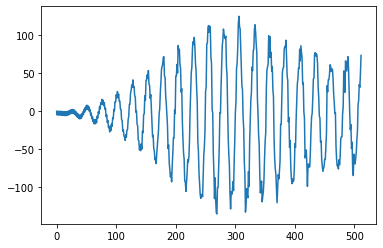

In [12]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=1)
plt.plot(X_train.values[int(idx)])
plt.show()

## MinMaxScale

In [13]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  FutureWarning,


# Wave

## randomforest

In [14]:
model = RandomForestClassifier(random_state=seed)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

F1: 0.8174687290387649


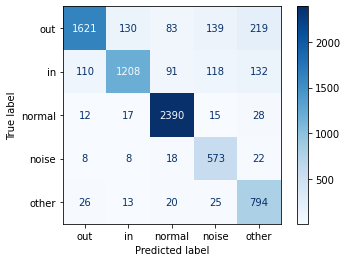

In [15]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

## lightgbm

In [16]:
model = lgbm.LGBMClassifier(random_state=seed)
model.fit(X_train, y_train)

LGBMClassifier(random_state=42)

F1: 0.7468906976870581


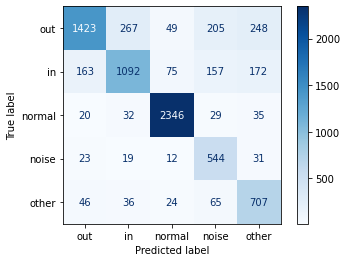

In [17]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

## catboost

In [18]:
model = cat.CatBoostClassifier(iterations=300, random_seed=seed)
model.fit(X_train, y_train)

Learning rate set to 0.27531
0:	learn: 1.4184771	total: 909ms	remaining: 4m 31s
1:	learn: 1.3234746	total: 1.68s	remaining: 4m 9s
2:	learn: 1.2594268	total: 2.34s	remaining: 3m 51s
3:	learn: 1.2070090	total: 3.07s	remaining: 3m 47s
4:	learn: 1.1674086	total: 3.85s	remaining: 3m 47s
5:	learn: 1.1376915	total: 4.48s	remaining: 3m 39s
6:	learn: 1.1154184	total: 5.07s	remaining: 3m 32s
7:	learn: 1.0897642	total: 5.65s	remaining: 3m 26s
8:	learn: 1.0779405	total: 6.1s	remaining: 3m 17s
9:	learn: 1.0542537	total: 6.75s	remaining: 3m 15s
10:	learn: 1.0391733	total: 7.31s	remaining: 3m 11s
11:	learn: 1.0273527	total: 7.87s	remaining: 3m 8s
12:	learn: 1.0144182	total: 8.45s	remaining: 3m 6s
13:	learn: 0.9970416	total: 9.11s	remaining: 3m 6s
14:	learn: 0.9882162	total: 9.62s	remaining: 3m 2s
15:	learn: 0.9762623	total: 10.3s	remaining: 3m 2s
16:	learn: 0.9693524	total: 10.8s	remaining: 2m 59s
17:	learn: 0.9602758	total: 11.3s	remaining: 2m 57s
18:	learn: 0.9540039	total: 11.9s	remaining: 2m 56s


F1: 0.769379697229926


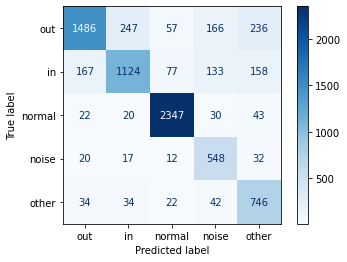

In [19]:
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

# MFCC

## MFCC transform

In [20]:
sr = 22050
X_train_mfcc = []
for y in tqdm(X_train):
    ret = librosa.feature.mfcc(y=y, sr=sr)
    X_train_mfcc.append(ret)

  0%|          | 0/90000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=512
  n_fft, y.shape[-1]


In [21]:
X_test_mfcc = []
for y in tqdm(X_test):
    ret = librosa.feature.mfcc(y=y, sr=sr)
    X_test_mfcc.append(ret)

  0%|          | 0/7820 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=512
  n_fft, y.shape[-1]


In [22]:
X_train_mfcc = np.array(X_train_mfcc)
X_test_mfcc = np.array(X_test_mfcc)

X_train_mfcc.shape, X_test_mfcc.shape

((90000, 20, 2), (7820, 20, 2))

In [23]:
X_train_mfcc_flatten = X_train_mfcc.reshape(X_train_mfcc.shape[0], -1)
X_test_mfcc_flatten = X_test_mfcc.reshape(X_test_mfcc.shape[0], -1)

X_train_mfcc_flatten.shape, X_test_mfcc_flatten.shape

((90000, 40), (7820, 40))

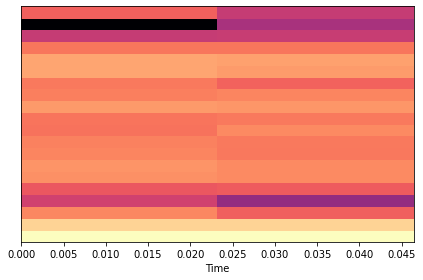

In [24]:
idx = np.random.randint(low=0, high=len(X_train_mfcc), size=1)
amp_db = librosa.amplitude_to_db(np.abs(X_train_mfcc[int(idx)]), ref=np.max)
librosa.display.specshow(amp_db, sr=sr, x_axis='time')
plt.tight_layout()
plt.show()

## randomforest

In [25]:
model = RandomForestClassifier(random_state=seed)
model.fit(X_train_mfcc_flatten, y_train)

RandomForestClassifier(random_state=42)

F1: 0.7067502403002215


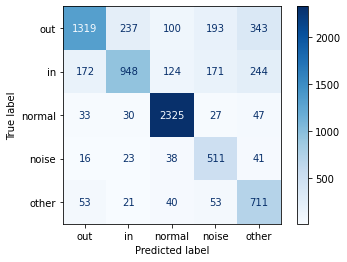

In [26]:
y_pred = model.predict(X_test_mfcc_flatten)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

## lightgbm

In [27]:
model = lgbm.LGBMClassifier(random_state=seed)
model.fit(X_train_mfcc_flatten, y_train)

LGBMClassifier(random_state=42)

F1: 0.6119658482735248


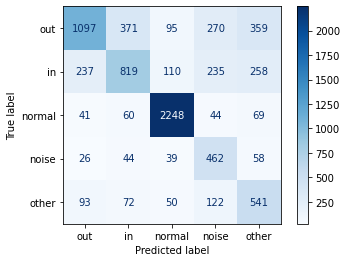

In [28]:
y_pred = model.predict(X_test_mfcc_flatten)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

## catboost

In [29]:
model = cat.CatBoostClassifier(iterations=300, random_seed=seed)
model.fit(X_train_mfcc_flatten, y_train)

Learning rate set to 0.27531
0:	learn: 1.4581962	total: 76.4ms	remaining: 22.9s
1:	learn: 1.3785685	total: 151ms	remaining: 22.4s
2:	learn: 1.3264413	total: 225ms	remaining: 22.3s
3:	learn: 1.2884568	total: 300ms	remaining: 22.2s
4:	learn: 1.2535182	total: 376ms	remaining: 22.2s
5:	learn: 1.2292758	total: 452ms	remaining: 22.2s
6:	learn: 1.2071380	total: 533ms	remaining: 22.3s
7:	learn: 1.1903943	total: 600ms	remaining: 21.9s
8:	learn: 1.1758312	total: 675ms	remaining: 21.8s
9:	learn: 1.1653585	total: 734ms	remaining: 21.3s
10:	learn: 1.1527519	total: 798ms	remaining: 21s
11:	learn: 1.1389914	total: 866ms	remaining: 20.8s
12:	learn: 1.1283934	total: 935ms	remaining: 20.6s
13:	learn: 1.1215244	total: 987ms	remaining: 20.2s
14:	learn: 1.1147195	total: 1.04s	remaining: 19.8s
15:	learn: 1.1073345	total: 1.1s	remaining: 19.6s
16:	learn: 1.0969481	total: 1.17s	remaining: 19.5s
17:	learn: 1.0918971	total: 1.22s	remaining: 19.2s
18:	learn: 1.0847693	total: 1.28s	remaining: 19s
19:	learn: 1.076

F1: 0.6589109473154405


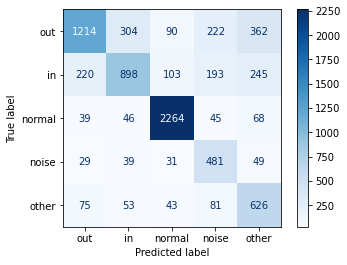

In [30]:
y_pred = model.predict(X_test_mfcc_flatten)
f1 = f1_score(y_test, y_pred, average='macro')

print(f'F1: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        cmap='Blues',
                                        display_labels=encoder.keys())
plt.show()

## DNN

In [31]:
y_train.shape, y_test.shape

((90000,), (7820,))

In [32]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train.shape, y_test.shape

((90000, 5), (7820, 5))

In [33]:
def build_dnn():
    model = models.Sequential()

    input = layers.Input(shape=X_train_mfcc_flatten.shape[1])

    output = layers.Dense(512, activation='relu')(input)
    output = layers.Dense(256, activation='relu')(output)
    output = layers.Dense(128, activation='relu')(output)
    output = layers.Dense(64, activation='relu')(output)
    output = layers.Dense(32, activation='relu')(output)
    output = layers.Dense(5, activation='softmax')(output)

    model = models.Model(inputs=[input], outputs=output)

    model.compile(optimizer=optimizers.Adamax(),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [34]:
model_dnn = build_dnn()
model_dnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense (Dense)               (None, 512)               20992     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 5)                 165   

In [35]:
history_dnn = model_dnn.fit(X_train_mfcc_flatten, y_train,
                            epochs=50, batch_size=128,
                            validation_data=(X_test_mfcc_flatten, y_test))

Epoch 1/50
704/704 [==============================] - 5s 3ms/step - loss: 1.1899 - acc: 0.5021 - val_loss: 0.9863 - val_acc: 0.5916
Epoch 2/50
704/704 [==============================] - 2s 3ms/step - loss: 1.0395 - acc: 0.5766 - val_loss: 1.0180 - val_acc: 0.5855
Epoch 3/50
704/704 [==============================] - 2s 3ms/step - loss: 0.9411 - acc: 0.6268 - val_loss: 0.9863 - val_acc: 0.6013
Epoch 4/50
704/704 [==============================] - 2s 3ms/step - loss: 0.8598 - acc: 0.6650 - val_loss: 0.8984 - val_acc: 0.6509
Epoch 5/50
704/704 [==============================] - 2s 3ms/step - loss: 0.7847 - acc: 0.6989 - val_loss: 0.9609 - val_acc: 0.6281
Epoch 6/50
704/704 [==============================] - 2s 3ms/step - loss: 0.7229 - acc: 0.7275 - val_loss: 0.9344 - val_acc: 0.6494
Epoch 7/50
704/704 [==============================] - 2s 3ms/step - loss: 0.6613 - acc: 0.7536 - val_loss: 0.8576 - val_acc: 0.6797
Epoch 8/50
704/704 [==============================] - 2s 3ms/step - loss: 0.

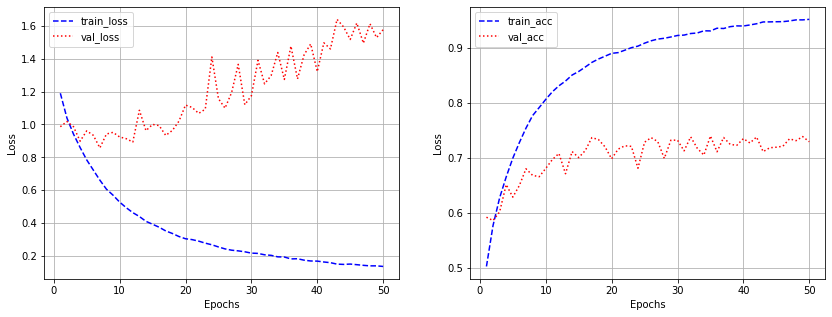

In [36]:
plot_history(history_dnn.history)

## CNN

In [37]:
X_train_mfcc_cnn = np.expand_dims(X_train_mfcc, -1)
X_test_mfcc_cnn = np.expand_dims(X_test_mfcc, -1)

X_train_mfcc_cnn.shape, X_test_mfcc_cnn.shape

((90000, 20, 2, 1), (7820, 20, 2, 1))

In [38]:
def build_cnn():

    model = models.Sequential()

    input = layers.Input(shape=X_train_mfcc_cnn.shape[1:])

    output = layers.Conv2D(128, 3, strides=1, padding='same', activation='relu')(input)
    output = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

    output = layers.Conv2D(256, 3, strides=1, padding='same', activation='relu')(output)
    output = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

    output = layers.Conv2D(512, 3, strides=1, padding='same', activation='relu')(output)
    output = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='same')(output)

    output = layers.Flatten()(output)

    output = layers.Dense(512, activation='relu')(output)
    output = layers.Dense(256, activation='relu')(output)
    output = layers.Dense(128, activation='relu')(output)

    output = layers.Dense(5, activation='softmax')(output)

    model = models.Model(inputs=[input], outputs=output)

    model.compile(optimizer=optimizers.Adamax(),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [39]:
model_cnn = build_cnn()
model_cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20, 2, 1)]        0         
                                                                 
 conv2d (Conv2D)             (None, 20, 2, 128)        1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 1, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 1, 256)        295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 1, 256)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 1, 512)         1180

In [40]:
history_cnn = model_cnn.fit(X_train_mfcc_cnn, y_train,
                            epochs=50, batch_size=128,
                            validation_data=(X_test_mfcc_cnn, y_test))

Epoch 1/50
704/704 [==============================] - 15s 8ms/step - loss: 1.2124 - acc: 0.4800 - val_loss: 1.0176 - val_acc: 0.5581
Epoch 2/50
704/704 [==============================] - 5s 7ms/step - loss: 0.9970 - acc: 0.5958 - val_loss: 0.9951 - val_acc: 0.5936
Epoch 3/50
704/704 [==============================] - 5s 7ms/step - loss: 0.8387 - acc: 0.6704 - val_loss: 0.8779 - val_acc: 0.6611
Epoch 4/50
704/704 [==============================] - 5s 7ms/step - loss: 0.6973 - acc: 0.7346 - val_loss: 0.9414 - val_acc: 0.6683
Epoch 5/50
704/704 [==============================] - 5s 7ms/step - loss: 0.5761 - acc: 0.7834 - val_loss: 0.8884 - val_acc: 0.6880
Epoch 6/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4829 - acc: 0.8204 - val_loss: 0.9981 - val_acc: 0.6850
Epoch 7/50
704/704 [==============================] - 5s 7ms/step - loss: 0.4102 - acc: 0.8517 - val_loss: 0.8808 - val_acc: 0.7295
Epoch 8/50
704/704 [==============================] - 5s 7ms/step - loss: 0

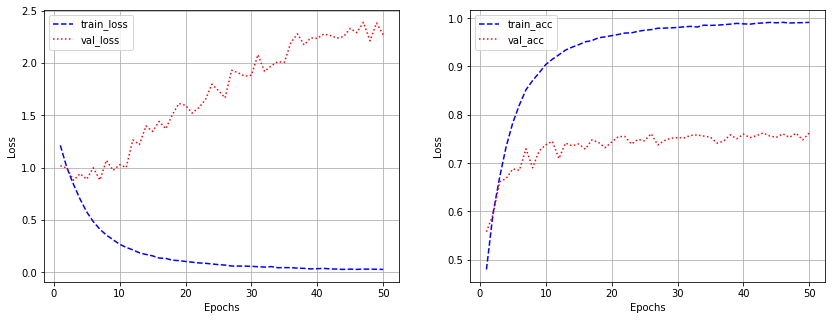

In [41]:
plot_history(history_cnn.history)